In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import multivariate_normal
import plotly.figure_factory as ff
import networkx as nx

### Inference in a Bayesian Network
Inference concerns finding the distribution over some unknown variables given some known/observed variables. <br>
Consider the below problem: <br>
You know both earthquakes and burglars have a chance to set off the alarm in your house. The alarm going off can cause Mary or Jane to call you. The factor graph representing the situation is below. Earthquakes (E) and Burglars (B) are independent. Mary calling (M) and Jane calling (J) are also independent given the Alarm (A). All variables are binary (0=no, 1=yes).    

In [2]:
def make_factor_graph(var_nodes,factor_nodes,labels,edges,positions):
    G=nx.DiGraph()
    G.add_nodes_from(var_nodes)
    G.add_nodes_from(factor_nodes)
    G.add_edges_from(edges)
    plt.figure(figsize=(4,4))
    nx.draw_networkx_nodes(G,positions,nodelist=var_nodes,node_shape='o',node_size=600,node_color="yellow")
    nx.draw_networkx_nodes(G,positions,nodelist=factor_nodes,node_shape='s',node_size=200,node_color="black")
    nx.draw_networkx_edges(G,positions,edgelist=edges,width=5,arrows=False)
    nx.draw_networkx_labels(G, positions,labels,font_size=16)
    plt.show()

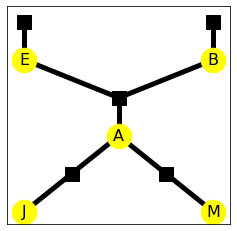

In [3]:
G1_variable_nodes = ["E","B","A","J","M"]
G1_factor_nodes = ["f1","f2","f3","f4","f5"]
G1labels = {"E":"E","B":"B","A":"A","J":"J","M":"M"}
G1_edges = [("f1","E"),("f2","B"),("E","f3"),("B","f3"),("f3","A"),("A","f4"),("A","f5"),("f4","J"),("f5","M")]
G1positions = {"E":[0,4],"B":[2,4],"A":[1,2],"J":[0,0],"M":[2,0],"f1":[0,5],"f2":[2,5],"f3":[1,3],"f4":[0.5,1],"f5":[1.5,1]}
make_factor_graph(G1_variable_nodes,G1_factor_nodes,G1labels,G1_edges,G1positions)

Say the conditional probabilities are known to you: <br>
$p(E^1)=0.03$ <br>
$p(B^1)=0.05$ <br>
$p(A^1|E^0,B^0) = 0.01$ <br>
$p(A^1|E^0,B^1) = 0.92$ <br>
$p(A^1|E^1,B^0) = 0.97$ <br>
$p(A^1|E^1,B^1) = 0.99$ <br>
$p(J^1|A^1)=0.75$ <br>
$p(J^1|A^0)=0.15$ <br>
$p(M^1|A^1)=0.95$ <br>
$p(M^1|A^0)=0.25$ <br>

The particular expansion of the joint: <br>
$p(E,B,A,J,M)=p(M|E,B,A,J)p(J|E,B,A)p(A|E,B)p(B|E)p(E)$ <br>
With the assumptions: <br>
$p(E,B,A,J,M)=p(M|A)p(J|A)p(A|E,B)p(B)p(E)$ <br>

In [8]:
f_M_given_A = np.array([0.95,0.25])
f_J_given_A = np.array([0.75,0.15])
f_A_given_E_B = np.array([0.01,0.92,0.97,0.99])
f_E = 0.03
f_B = 0.05

Using this information we can find the probability of a specific outcome easily: <br>

In [9]:
def get_joint_earthquake_burglar_example(E,B,A,J,M):
    prob_E = f_E if E==1 else 1-f_E
    prob_B = f_B if B==1 else 1-f_B
    prob_A_is_1 = f_A_given_E_B[E*2+B]
    prob_A = prob_A_is_1 if A==1 else 1-prob_A_is_1
    prob_J = f_J_given_A[A] if J==1 else 1-f_J_given_A[A]
    prob_M = f_M_given_A[A] if M==1 else 1-f_M_given_A[A]
    joint = prob_E*prob_B*prob_A*prob_J*prob_M
    return joint

print(get_joint_earthquake_burglar_example(1,0,1,1,0)) #Earthquake, Alarm, Jane calls

0.0031100624999999995


In [10]:
# check all the joint probabilities sum to 1.
total = 0
for E in range(2):
    for B in range(2):
        for A in range(2):
            for J in range(2):
                for M in range(2):
                    total+=get_joint_earthquake_burglar_example(E,B,A,J,M)
assert(np.isclose(total,1))

When doing inference you condition the variables you don't know on the variables you do know. Say we want to know the probability of an earthquake given Jane and Mary called. Then we want to know: <br>
$p(E^1|J^1,M^1) = p(E^1,J^1,M^1)\div p(J^1,M^1)$ <br>
The joint distributions in the numerator and denominator can be found by conditioning on the variables you know and marginalizing out the variables you don't know: <br>
$p(E^1,J^1,M^1) = \sum_B\sum_A p(E^1,B,A,J^1,M^1)$ <br>
$p(J^1,M^1) = \sum_E\sum_B\sum_A p(E,B,A,J^1,M^1)$ <br>

In [11]:
numerator = 0
for B in range(2):
    for A in range(2):
        numerator+=get_joint_earthquake_burglar_example(1,B,A,1,1)
        
denominator = 0
for E in range(2):
    for B in range(2):
        for A in range(2):
            denominator+=get_joint_earthquake_burglar_example(E,B,A,1,1)
            
conditional_prob_of_E = numerator/denominator
print(conditional_prob_of_E, "prob Earthquake given Jane called")

0.002608154739090277 prob Earthquake given Jane called


So, to do inference we condition on the variables we know and marginalize those we do not know. On a directed pgm this is simple, as shown above. On undirected pgms the same can be done, but requires thinking about factors instead. The next notebook will cover the same example with factors. 